In [2]:
import sys
import numpy as np
import pandas as pd
from scipy.misc import imread
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng
from keras.utils import plot_model
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask
from keras.callbacks import ModelCheckpoint, TensorBoard
from time import time
import glob


### Please give below paths as per the paths in your system

In [3]:
train_folder = "data/images_background/"
val_folder = 'data/images_evaluation/'
save_path = 'data/'

In [4]:
def loadimgs(path,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    # we load every alphabet seperately so we can isolate them later
    for alphabet in [x for x in os.listdir(path) if not x.startswith('.')]:
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        # every letter/category has it's own column in the array, so  load seperately
        for letter in [x for x in os.listdir(alphabet_path) if not x.startswith('.')]:
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            # read all the images in the current category
            for filename in [x for x in os.listdir(letter_path) if not x.startswith('.')]:
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

### Loading the train images into tensors

In [5]:
X,y,c=loadimgs(train_folder)

loading alphabet: Gujarati


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


loading alphabet: Korean
loading alphabet: Arcadian
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Grantha
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Balinese
loading alphabet: Futurama
loading alphabet: N_Ko
loading alphabet: Burmese_(Myanmar)
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: Latin
loading alphabet: Braille
loading alphabet: Sanskrit
loading alphabet: Japanese_(hiragana)
loading alphabet: Tagalog
loading alphabet: Greek
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Japanese_(katakana)
loading alphabet: Early_Aramaic
loading alphabet: Hebrew
loading alphabet: Tifinagh
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Armenian
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Cyrillic
loading alphabet: Bengali
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)


### Saving the train tensors on disk

In [6]:
with open(os.path.join(save_path,"train.pickle"), "wb") as f:
    pickle.dump((X,c),f)

### Loading the validation images into tensors

In [7]:
Xval,yval,cval=loadimgs(val_folder)

loading alphabet: Oriya


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


loading alphabet: ULOG
loading alphabet: Tengwar
loading alphabet: Malayalam
loading alphabet: Atlantean
loading alphabet: Keble
loading alphabet: Manipuri
loading alphabet: Gurmukhi
loading alphabet: Tibetan
loading alphabet: Aurek-Besh
loading alphabet: Ge_ez
loading alphabet: Angelic
loading alphabet: Old_Church_Slavonic_(Cyrillic)
loading alphabet: Kannada
loading alphabet: Avesta
loading alphabet: Mongolian
loading alphabet: Syriac_(Serto)
loading alphabet: Atemayar_Qelisayer
loading alphabet: Sylheti
loading alphabet: Glagolitic


### Saving the validation tensors on disk

In [8]:
with open(os.path.join(save_path,"val.pickle"), "wb") as f:
    pickle.dump((Xval,cval),f)

In [9]:
# del X, y ,c ,Xval, yval, cval

In [10]:
def initialize_weights(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [11]:
def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [12]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [24]:
def get_capsnet_model(input_shape, n_class, routings):

    left_input = Input(shape=input_shape)
    right_input = Input(shape=input_shape)

    input = Input(shape=input_shape)
    # Layer 1: Just a conventional Conv2D layer
    conv1 = Conv2D(filters=64, kernel_size=36, strides=1, padding='valid', activation='relu', name='conv1')(input)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=4, n_channels=16, kernel_size=18, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                             name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    tunnel = Model(input, out_caps)
    tunnel.summary()

    encoded_l = tunnel(left_input)
    encoded_r = tunnel(right_input)

    L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    prediction = Dense(1, activation='sigmoid')(L1_distance)

    train_model = Model(inputs=[left_input, right_input], outputs=prediction)

    return train_model


In [25]:
ckpts = glob.glob("checkpoints/*.hdf5")
if len(ckpts) != 0:
    latest_ckpt = max(ckpts, key=os.path.getctime)
    print("loading from checkpoint: ", latest_ckpt)
    initial_epoch = int(latest_ckpt[latest_ckpt.find("-epoch-") + len("-epoch-"):latest_ckpt.rfind("-lr-")])
    model = load_model(latest_ckpt)
else:    
    model = get_capsnet_model(input_shape=[105, 105, 1], n_class=10, routings=3)
#     model = get_siamese_model((105, 105, 1))
model.summary()
plot_model(model, to_file='model.png')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 105, 105, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 70, 70, 64)        83008     
_________________________________________________________________
primarycap_conv2d (Conv2D)   (None, 27, 27, 64)        1327168   
_________________________________________________________________
primarycap_reshape (Reshape) (None, 11664, 4)          0         
_________________________________________________________________
primarycap_squash (Lambda)   (None, 11664, 4)          0         
_________________________________________________________________
digitcaps (CapsuleLayer)     (None, 10, 16)            7464960   
_________________________________________________________________
capsnet (Length)             (None, 10)                0         
Total para

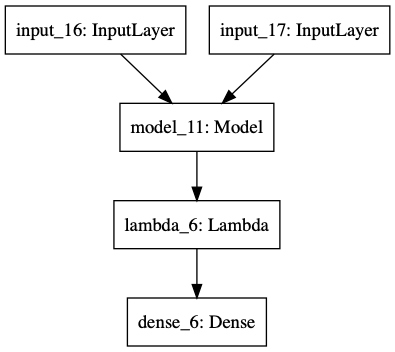

In [26]:
from IPython.display import Image
Image(retina=True, filename='model.png')

In [27]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

W0628 10:04:50.990446 4724458944 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0628 10:04:50.995942 4724458944 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0628 10:04:51.000432 4724458944 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Loading the train tensors

In [28]:
with open(os.path.join(save_path, "train.pickle"), "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(train_classes.keys()))

Training alphabets: 

['Gujarati', 'Korean', 'Arcadian', 'Malay_(Jawi_-_Arabic)', 'Grantha', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Balinese', 'Futurama', 'N_Ko', 'Burmese_(Myanmar)', 'Anglo-Saxon_Futhorc', 'Mkhedruli_(Georgian)', 'Latin', 'Braille', 'Sanskrit', 'Japanese_(hiragana)', 'Tagalog', 'Greek', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Japanese_(katakana)', 'Early_Aramaic', 'Hebrew', 'Tifinagh', 'Asomtavruli_(Georgian)', 'Armenian', 'Syriac_(Estrangelo)', 'Alphabet_of_the_Magi', 'Cyrillic', 'Bengali', 'Inuktitut_(Canadian_Aboriginal_Syllabics)']


In [29]:
with open(os.path.join(save_path, "val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)

print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Validation alphabets:

['Oriya', 'ULOG', 'Tengwar', 'Malayalam', 'Atlantean', 'Keble', 'Manipuri', 'Gurmukhi', 'Tibetan', 'Aurek-Besh', 'Ge_ez', 'Angelic', 'Old_Church_Slavonic_(Cyrillic)', 'Kannada', 'Avesta', 'Mongolian', 'Syriac_(Serto)', 'Atemayar_Qelisayer', 'Sylheti', 'Glagolitic']


In [30]:
def get_batch(batch_size,s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape

    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
    
    return pairs, targets

In [31]:
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

In [32]:
def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape
    
    indices = rng.randint(0, n_examples,size=(N,))
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low,high),size=(N,),replace=False)

    else: # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)            
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

In [33]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [34]:
# Hyper parameters
evaluate_every = 2 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 20000 # No. of training iterations
N_way = 20 # how many classes for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

In [35]:
model_path = 'weights/cnn_siamese'

In [36]:
os.makedirs("checkpoints", exist_ok=True)
file_path = "checkpoints/siamese-epoch-{epoch:05d}-lr-" + "-train_loss-{loss:.4f}-val_loss-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(file_path,
                             monitor=['loss', 'val_loss'],
                             verbose=1,
                             save_best_only=False,
                             save_weights_only=False,
                             mode='min',
                             period=2)
tensorboard = TensorBoard(log_dir="logs/{}".format(time()), histogram_freq=0)


In [ ]:
model.fit_generator(generator=generate(32), 
                    steps_per_epoch=100, 
                    epochs=10, 
                    validation_data=generate(32, 'val'), 
                    validation_steps=2,
                    callbacks=[checkpoint, tensorboard],
                    use_multiprocessing=True)

W0628 10:05:03.029168 4724458944 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0628 10:05:04.424057 4724458944 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0628 10:05:04.426373 4724458944 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/10
  2/100 [..............................] - ETA: 10:41 - loss: 0.6933

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

### Load model weights

In [ ]:
model.load_weights(os.path.join(model_path, "weights.20000.h5"))

### Testing

### Baseline model based on Nearest Neighbors using Euclidean distance (L2 distance)

In [ ]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [ ]:
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [ ]:
ways = np.arange(1,20,2)
resume =  False
trials = 50

In [ ]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
    val_accs.append(test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("---------------------------------------------------------------------------------------------------------------")

### Save the accuracies on disk

In [ ]:
with open(os.path.join(save_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs,nn_accs),f)

### Load the accuracies from disk

In [ ]:
with open(os.path.join(save_path, "accuracies.pickle"), "rb") as f:
    (val_accs, train_accs, nn_accs) = pickle.load(f)

### Below two functions are used for visualizing test image and support set

In [ ]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [ ]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
# Example of concat image visualization
pairs, targets = make_oneshot_task(16,"train","Sanskrit")
plot_oneshot_task(pairs)

### Resuts

In [ ]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = make_oneshot_task(20, "val", 'Oriya')
plt.show()

plot_oneshot_task(inputs)